# CELL 1: Environment & GPU Setup

In [1]:
# ============================================================================
# CELL 1: Environment & GPU Setup
# ============================================================================
# Install/reinstall main packages to ensure compatibility
!pip install torch torchvision torchaudio mediapipe
!pip install numpy==1.26.4 scipy==1.12.0 scikit-learn==1.5.2

# Import libraries
import torch
import numpy as np
import random
import pickle
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
import mediapipe as mp
import os
import glob
from tqdm import tqdm
import json
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CELL 2: Configuration & Constants

In [2]:
# ============================================================================
# CELL 2: Configuration & Constants
# ============================================================================
# Paths
BASE_INPUT_DIR = "/content/drive/MyDrive/KSL_Project/KSL_Videos"
OUTPUT_SKELETON_DIR = "/content/drive/MyDrive/KSL_Project/KSL_JOINT_STREAM"

# Model parameters
SEQUENCE_LENGTH = 32
NUM_JOINTS = 47
POSE_INDICES = [0, 11, 12, 13, 14]  # Nose, Shoulders, Elbows

# Retry settings
MAX_RETRIES = 5
INITIAL_DELAY_SECONDS = 2


# CELL 3: MediaPipe Holistic Setup & Landmark Extraction

In [ ]:
# ============================================================================
# CELL 3: MediaPipe Holistic Setup & Landmark Extraction
# ============================================================================
mp_holistic = mp.solutions.holistic

def extract_landmarks_from_frame(results):
    """Extracts 47 keypoints from hands + pose."""
    frame_coords = np.zeros((NUM_JOINTS, 3), dtype=np.float32)

    # Left hand
    if results.left_hand_landmarks:
        for i, lm in enumerate(results.left_hand_landmarks.landmark):
            frame_coords[i] = [lm.x, lm.y, lm.z]

    # Right hand
    if results.right_hand_landmarks:
        for i, lm in enumerate(results.right_hand_landmarks.landmark):
            frame_coords[i + 21] = [lm.x, lm.y, lm.z]

    # Pose keypoints
    if results.pose_landmarks:
        for i, pose_index in enumerate(POSE_INDICES):
            lm = results.pose_landmarks.landmark[pose_index]
            frame_coords[i + 42] = [lm.x, lm.y, lm.z]

    return frame_coords


# CELL 4: Video Preprocessing Function

In [ ]:
# ============================================================================
# CELL 4: Video Preprocessing Function
# ============================================================================
def preprocess_video(video_path):
    """Process video, extract landmarks, and pad/trim to SEQUENCE_LENGTH."""
    cap = None
    delay = INITIAL_DELAY_SECONDS

    for attempt in range(MAX_RETRIES):
        cap = cv2.VideoCapture(video_path)
        if cap.isOpened():
            break
        print(f"[Attempt {attempt+1}/{MAX_RETRIES}] Failed to open {video_path}, retrying in {delay}s...")
        cap.release()
        time.sleep(delay)
        delay *= 2

    if not cap or not cap.isOpened():
        print(f"[FATAL] Skipped video: {video_path}")
        return np.zeros((SEQUENCE_LENGTH, NUM_JOINTS, 3), dtype=np.float32)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices_to_sample = np.linspace(0, total_frames - 1, SEQUENCE_LENGTH, dtype=int) if total_frames > 0 else []

    joint_data = []
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        current_frame = 0
        frame_idx = 0
        while cap.isOpened() and frame_idx < SEQUENCE_LENGTH:
            ret, frame = cap.read()
            if not ret:
                break
            if current_frame in indices_to_sample and frame_idx < SEQUENCE_LENGTH:
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False
                results = holistic.process(image)
                coords = extract_landmarks_from_frame(results)
                joint_data.append(coords)
                frame_idx += 1
            current_frame += 1
    cap.release()

    # Pad or trim
    joint_data = np.array(joint_data, dtype=np.float32)
    if joint_data.shape[0] < SEQUENCE_LENGTH:
        padding = np.zeros((SEQUENCE_LENGTH - joint_data.shape[0], NUM_JOINTS, 3), dtype=np.float32)
        joint_data = np.concatenate([joint_data, padding], axis=0)
    elif joint_data.shape[0] > SEQUENCE_LENGTH:
        joint_data = joint_data[:SEQUENCE_LENGTH]

    return joint_data


# CELL 5: Main Video Processing Loop

In [ ]:
# ============================================================================
# CELL 5: Main Video Processing Loop
# ============================================================================
def process_all_videos():
    """Extract features from all videos recursively and save as pickle."""
    if not os.path.exists(BASE_INPUT_DIR):
        print(f"Input directory not found: {BASE_INPUT_DIR}")
        return

    os.makedirs(OUTPUT_SKELETON_DIR, exist_ok=True)
    print(f"Output directory ready: {OUTPUT_SKELETON_DIR}")

    video_files = glob.glob(os.path.join(BASE_INPUT_DIR, '**', '*.[mM][pP]4'), recursive=True)
    if not video_files:
        print(f"No videos found in {BASE_INPUT_DIR}")
        return
    print(f"Found {len(video_files)} video files.")

    all_features, all_labels = [], []
    for video_path in tqdm(video_files, desc="Processing Videos"):
        try:
            class_label = int(os.path.basename(os.path.dirname(video_path)))
            joint_data = preprocess_video(video_path)
            if np.all(joint_data == 0):
                continue
            joint_data = joint_data.transpose(2, 0, 1)  # (3, 32, 47)
            all_features.append(joint_data)
            all_labels.append(class_label)
        except Exception as e:
            print(f"Error processing {video_path}: {e}")

    final_features = np.array(all_features, dtype=np.float32)
    final_labels = np.array(all_labels, dtype=np.int64)

    output_pkl_path = os.path.join(OUTPUT_SKELETON_DIR, "KSL77_joint_stream_47pt.pkl")
    with open(output_pkl_path, 'wb') as f:
        pickle.dump((final_features, final_labels), f)

    print(f"\nProcessed {final_features.shape[0]} videos. Data saved to {output_pkl_path}")

# Run the processing
if __name__ == '__main__':
    process_all_videos()


# CELL 6: Load Processed Data & Create Datasets

In [48]:
# ============================================================================
# CELL 6: Load Processed Data & Create Datasets
# ============================================================================
data_path = "/content/drive/MyDrive/KSL_Project/KSL_JOINT_STREAM/KSL77_joint_stream_47pt.pkl"
with open(data_path, "rb") as f:
    features, labels = pickle.load(f)

print("Loaded features:", features.shape)
print("Loaded labels:", labels.shape)

features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

class PoseDataset(Dataset):
    """PyTorch Dataset for KSL joint features, with optional augmentation."""
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].clone()
        y = self.y[idx]
        if self.augment:
            x = self.apply_augmentations(x)
        return x, y

    def apply_augmentations(self, x):
        if random.random() < 0.5: x += torch.randn_like(x) * 0.01
        if random.random() < 0.3: x *= 1.0 + (random.random() - 0.5) * 0.1
        if random.random() < 0.3: x = torch.roll(x, shifts=random.randint(-2,2), dims=1)
        if random.random() < 0.3: x[0] = -x[0]
        return x

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)
unique_labels = torch.unique(labels)
label_map = {old.item(): new for new, old in enumerate(unique_labels)}
y_train = torch.tensor([label_map[int(l)] for l in y_train])
y_test = torch.tensor([label_map[int(l)] for l in y_test])
reverse_label_map = {v: k for k, v in label_map.items()}
num_classes = len(unique_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

# DataLoaders
train_loader = DataLoader(PoseDataset(X_train, y_train, augment=True), batch_size=32, shuffle=True)
val_loader = DataLoader(PoseDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(PoseDataset(X_test, y_test), batch_size=32, shuffle=False)

print(f"DataLoaders ready: Train {len(train_loader)}, Val {len(val_loader)}, Test {len(test_loader)}")


Loaded features: (1228, 3, 32, 47)
Loaded labels: (1228,)
DataLoaders ready: Train 28, Val 4, Test 8


In [49]:
print("--- Clearing Model Checkpoints and Final Save File ---")

# Checkpoint saved during the final training loop (CELL 8)
CHECKPOINT_NAME = "best_model_tuned.pt"

# Final model saved to Google Drive (CELL 9)
FINAL_SAVE_PATH = "/content/drive/MyDrive/KSL_Project/best_model_tuned_final.pt"

# 1. Delete the local checkpoint (must be deleted before training in CELL 8)
!rm -f {CHECKPOINT_NAME}
print(f"Deleted local checkpoint: {CHECKPOINT_NAME}")

# 2. Delete the final model saved to Drive (optional, but good for freshness)
!rm -f {FINAL_SAVE_PATH}
print(f"Deleted Drive backup: {FINAL_SAVE_PATH}")

print("Cleanup complete. Ready for fresh training run.")

--- Clearing Model Checkpoints and Final Save File ---
Deleted local checkpoint: best_model_tuned.pt
Deleted Drive backup: /content/drive/MyDrive/KSL_Project/best_model_tuned_final.pt
Cleanup complete. Ready for fresh training run.


# CELL 7: Model Definition - PoseCNN_LSTM_Attn

In [50]:
import torch.nn as nn
import torch.nn.functional as F

class PoseCNN_LSTM_Attn_Tunable(nn.Module):
    def __init__(self, num_classes, cnn_hidden=128, lstm_hidden=128, dropout_rate=0.3):
        super().__init__()

        # We tune the number of filters in the second block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,5), padding=(0,2))
        self.bn1 = nn.BatchNorm2d(64)

        # Use cnn_hidden here
        self.conv2 = nn.Conv2d(64, cnn_hidden, kernel_size=(1,3), padding=(0,1))
        self.bn2 = nn.BatchNorm2d(cnn_hidden)

        self.pool = nn.MaxPool2d((1,2))
        self.dropout = nn.Dropout(dropout_rate) # Use tunable dropout

        # Use cnn_hidden here
        self.temp_conv = nn.Conv2d(cnn_hidden, cnn_hidden, kernel_size=(3,1), padding=(1,0))
        self.bn_temp = nn.BatchNorm2d(cnn_hidden)

        # Calculate LSTM input size dynamically based on cnn_hidden
        # Note: (47//2) assumes your input width is fixed.
        self.lstm = nn.LSTM(input_size=cnn_hidden*(47//2), hidden_size=lstm_hidden, num_layers=1, batch_first=True, bidirectional=True)

        self.attn = nn.Sequential(nn.Linear(lstm_hidden*2, lstm_hidden), nn.Tanh(), nn.Linear(lstm_hidden, 1))

        self.fc = nn.Sequential(
            nn.BatchNorm1d(lstm_hidden*2),
            nn.Linear(lstm_hidden*2, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # (Same forward pass as before)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.bn_temp(self.temp_conv(x)))
        x = x.permute(0,2,1,3).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        out,_ = self.lstm(x)
        attn_scores = self.attn(out)
        attn_weights = torch.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights*out, dim=1)
        return self.fc(context)

In [52]:
pip install optuna

In [53]:
import optuna
import torch.optim as optim

def objective(trial):
    # 1. Suggest Hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    cnn_hidden = trial.suggest_categorical("cnn_hidden", [64, 128, 256])
    lstm_hidden = trial.suggest_categorical("lstm_hidden", [64, 128, 256])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])

    # 2. Setup Model & Optimizer with these params
    model = PoseCNN_LSTM_Attn_Tunable(
        num_classes=num_classes,
        cnn_hidden=cnn_hidden,
        lstm_hidden=lstm_hidden,
        dropout_rate=dropout_rate
    ).to(device)

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    # 3. Short Training Loop (e.g., 10 epochs just to test potential)
    # We use fewer epochs for tuning to save time.
    for epoch in range(10):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 4. Validation (Optuna needs to know how well this trial did)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total

        # Optional: Pruning (stop bad trials early)
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc

# 5. Run the Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20) # Try 20 different combinations

print("Best params found:")
print(study.best_params)

[I 2025-12-10 01:39:10,241] A new study created in memory with name: no-name-bcac642a-d154-453d-af78-a3d14fe9eef5
[I 2025-12-10 01:39:23,271] Trial 0 finished with value: 0.6666666666666666 and parameters: {'lr': 0.00024543612520321967, 'dropout_rate': 0.16433585503104237, 'cnn_hidden': 256, 'lstm_hidden': 256, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6666666666666666.
[I 2025-12-10 01:39:28,089] Trial 1 finished with value: 0.13131313131313133 and parameters: {'lr': 6.333148036943983e-05, 'dropout_rate': 0.12606291276011883, 'cnn_hidden': 128, 'lstm_hidden': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6666666666666666.
[I 2025-12-10 01:39:31,780] Trial 2 finished with value: 0.06060606060606061 and parameters: {'lr': 1.936391579463355e-05, 'dropout_rate': 0.12915747112061876, 'cnn_hidden': 128, 'lstm_hidden': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6666666666666666.
[I 2025-12-10 01:39:38,136] Trial 3 finished with value: 0.32323232323232326 and 

Best params found:
{'lr': 0.0003421517873280485, 'dropout_rate': 0.2224530595939839, 'cnn_hidden': 64, 'lstm_hidden': 256, 'optimizer': 'Adam'}


In [54]:
best_params = study.best_params

final_model = PoseCNN_LSTM_Attn_Tunable(
    num_classes=num_classes,
    cnn_hidden=best_params['cnn_hidden'],
    lstm_hidden=best_params['lstm_hidden'],
    dropout_rate=best_params['dropout_rate']
).to(device)

# CELL 8: Training Loop

Using Tuned Parameters: {'lr': 0.0003421517873280485, 'dropout_rate': 0.2224530595939839, 'cnn_hidden': 64, 'lstm_hidden': 256, 'optimizer': 'Adam'}
Starting training with optimized model...
Epoch 0: Train Acc: 0.0340 | Val Acc: 0.0404 (New Best)
Epoch 1: Train Acc: 0.0838 | Val Acc: 0.1212 (New Best)
Epoch 2: Train Acc: 0.1314 | Val Acc: 0.1818 (New Best)
Epoch 3: Train Acc: 0.1880 | Val Acc: 0.2323 (New Best)
Epoch 4: Train Acc: 0.2276 | Val Acc: 0.2727 (New Best)
Epoch 5: Train Acc: 0.3273 | Val Acc: 0.3939 (New Best)
Epoch 6: Train Acc: 0.4326 | Val Acc: 0.4242 (New Best)
Epoch 7: Train Acc: 0.4813 | Val Acc: 0.4949 (New Best)
Epoch 8: Train Acc: 0.5617 | Val Acc: 0.5152 (New Best)
Epoch 9: Train Acc: 0.6353 | Val Acc: 0.5758 (New Best)
Epoch 10: Train Acc: 0.6693 | Val Acc: 0.6364 (New Best)
Epoch 11: Train Acc: 0.7022 | Val Acc: 0.6364 | No Improv (1/10)
Epoch 12: Train Acc: 0.7157 | Val Acc: 0.6566 (New Best)
Epoch 13: Train Acc: 0.7724 | Val Acc: 0.7172 (New Best)
Epoch 14: Tra

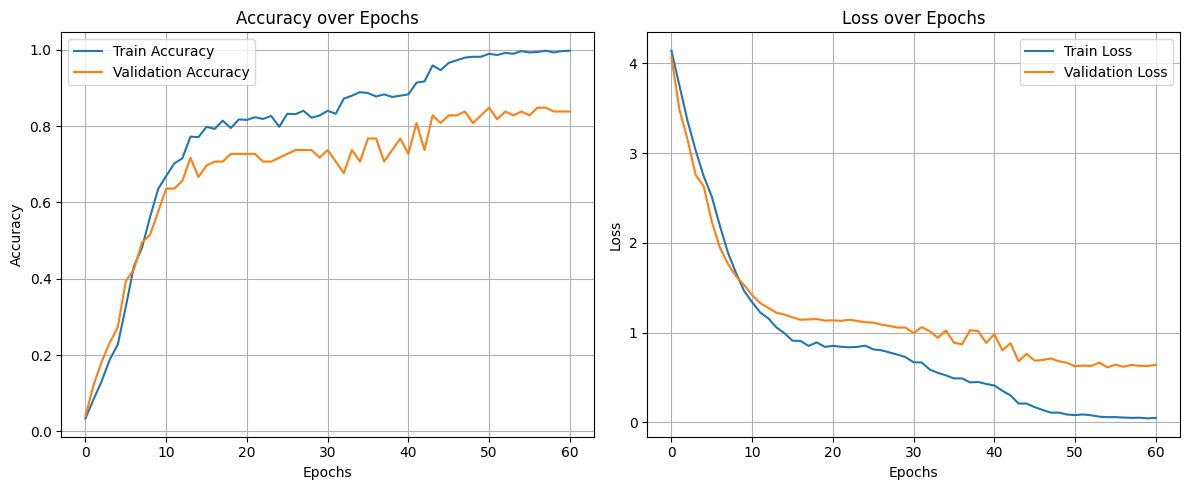

In [55]:
# ============================================================================
# CELL 8: Training Loop with Best Parameters
# ============================================================================
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Retrieve the best parameters from your study
# (Ensure 'study' was run in a previous cell, otherwise define best_params manually)
try:
    best_params = study.best_params
    print("Using Tuned Parameters:", best_params)
except NameError:
    print("Study not found. Using default parameters.")
    best_params = {
        'cnn_hidden': 128,
        'lstm_hidden': 128,
        'dropout_rate': 0.3,
        'lr': 0.001,
        'optimizer': 'Adam'
    }

# 2. Initialize the model with these parameters
# Note: Use the 'Tunable' class name if that is what you defined in Cell 7
final_model = PoseCNN_LSTM_Attn_Tunable(
    num_classes=num_classes,
    cnn_hidden=best_params['cnn_hidden'],
    lstm_hidden=best_params['lstm_hidden'],
    dropout_rate=best_params['dropout_rate']
).to(device)

# 3. Initialize Optimizer using the tuned Learning Rate (and type if you tuned it)
if best_params.get('optimizer') == 'RMSprop':
    optimizer = optim.RMSprop(final_model.parameters(), lr=best_params['lr'])
else:
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])

criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# --- HELPER FUNCTIONS ---
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Calculate val loss
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total, running_loss / len(dataloader.dataset)

# --- MAIN LOOP ---
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_acc, patience, trigger = 0, 10, 0
num_epochs = 100

print("Starting training with optimized model...")

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(final_model, train_loader, optimizer, criterion, device)
    val_acc, val_loss = evaluate(final_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Early Stopping Check
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(final_model.state_dict(), "best_model_tuned.pt") # Saved with different name
        print(f"Epoch {epoch}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} (New Best)")
        trigger = 0
    else:
        trigger += 1
        print(f"Epoch {epoch}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | No Improv ({trigger}/{patience})")
        if trigger >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    scheduler.step()

# --- PLOTTING ---
plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# CELL 9: Test & Evaluation

Successfully loaded tuned weights from best_model_tuned.pt
Running evaluation on Test Set...
Test Accuracy: 88.21%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         4
           3       1.00      0.50      0.67         4
           4       1.00      1.00      1.00         4
           5       0.67      1.00      0.80         4
           6       1.00      1.00      1.00         4
           7       1.00      0.75      0.86         4
           8       1.00      0.75      0.86         4
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       0.33      0.25      0.29         4
          12       1.00      1.00      1.00         3
          13       0.67      0.67      0.67         3
          14       1.00      1.00      1.00       

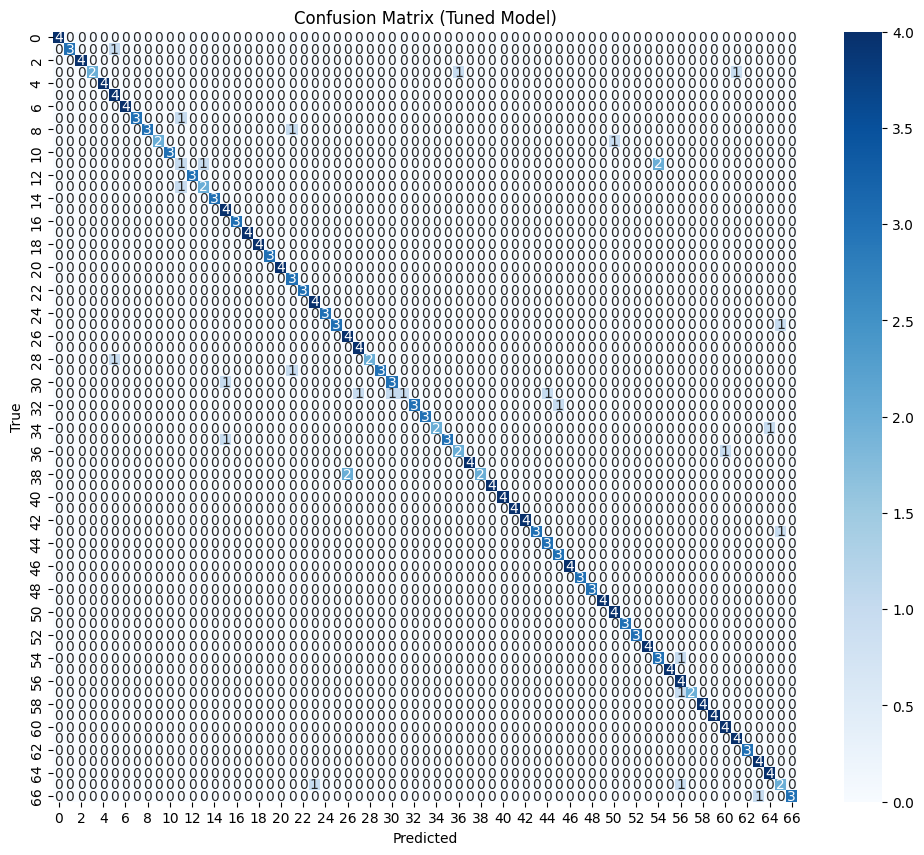

Final Tuned Model saved to /content/drive/MyDrive/KSL_Project/best_model_tuned_final.pt


In [56]:
# ============================================================================
# CELL 9: Test & Evaluation (Updated for Tuned Model)
# ============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch

# 1. Re-initialize the architecture with the SAME params used in training
# (We need to do this to ensure the structure matches the weights we are about to load)
# If 'best_params' is still in memory from the previous cell, we use it.
# Otherwise, we define a fallback (make sure these match your best run if you restarted runtime!)
try:
    params_to_use = study.best_params
except NameError:
    # If you restarted the runtime, manually input your best params here:
    print("Study object not found. Using fallback parameters.")
    params_to_use = {
        'cnn_hidden': 128,
        'lstm_hidden': 128,
        'dropout_rate': 0.3
    }

final_model = PoseCNN_LSTM_Attn_Tunable(
    num_classes=num_classes,
    cnn_hidden=params_to_use['cnn_hidden'],
    lstm_hidden=params_to_use['lstm_hidden'],
    dropout_rate=params_to_use['dropout_rate']
).to(device)

# 2. Load the Best Weights (from the tuned training run)
weight_path = "best_model_tuned.pt"
try:
    final_model.load_state_dict(torch.load(weight_path))
    print(f"Successfully loaded tuned weights from {weight_path}")
except FileNotFoundError:
    print(f"Warning: {weight_path} not found. Using current model weights (might be the last epoch).")

# 3. Evaluation Loop
final_model.eval()
all_preds = []
all_labels = []

print("Running evaluation on Test Set...")

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = final_model(X_batch)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# 4. Calculate Accuracy
correct_count = sum(p == l for p, l in zip(all_preds, all_labels))
test_acc = correct_count / len(all_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# 5. Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 6. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

# 7. Save Final Model to Drive (Optional Backup)
save_path = "/content/drive/MyDrive/KSL_Project/best_model_tuned_final.pt"
torch.save(final_model.state_dict(), save_path)
print(f"Final Tuned Model saved to {save_path}")